ФИО: Дорожинский Владислав Игоревич

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable, grad
from utils import create_dataloader
from torch.utils.data import Dataset, DataLoader

from skimage import io
import numpy as np
from os import listdir
from os.path import isfile, join
import time
import sys

# Perceptual Loss stuf
sys.path.insert(0, './PerceptualSimilarity')
import util
import perceptual_loss
from models import dist_model as dm
from models.base_model import BaseModel

# Perceptual Score stuff
sys.path.insert(0, './inception-score-pytorch/')
from inception_score import inception_score

torch.cuda.set_device(3)
%matplotlib inline

In [ ]:
import importlib

In [ ]:
#importlib.reload(models)

In [3]:
def get_noise(bs=16, noise_size=50):
    return Variable(torch.FloatTensor(bs, noise_size).normal_(0, 1), requires_grad=False)

In [4]:
class DataAcc:
    def __init__(self, dataloader):
        self.dl = dataloader
        self.it = iter(self.dl)
        
    def reset(self):
        self.it = iter(self.dl)
    
    def get_next(self):
        res = None
        try:
            res = next(self.it)
        except:
            print('DataAcc reinit')
            self.reset()
            res = next(self.it)
        return res

# data_acc = DataAcc(dataloader)

### Creating config object (argparse workaround)

In [5]:
class Config:
    pass

config = Config()
config.mnist_path = None#'../data/mnist'
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [6]:
dataloader = create_dataloader(config)

In [7]:
len(dataloader)

3750

In [8]:
for image, cat in dataloader:
    break

In [9]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [11]:
# generator = Generator().cuda()
# discriminator = Discriminator().cuda()

### Create optimizers and loss

In [12]:
# optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
# optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

### Create necessary variables

In [13]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### Main loop

#### GAN on MNIST

In [14]:
# criterion = nn.BCELoss()
# for epoch in range(config.num_epochs):
#     for iteration, (images, cat) in enumerate(dataloader):
#         ####### 
#         # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
#         #######
#         discriminator.zero_grad()
        
#         # real
#         images = Variable(images, requires_grad=False).view(-1, 784).cuda()
#         loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
#         loss.backward()
#         errD_x = loss.data[0]
        
#         # fake
#         fake_images = generator(get_noise().cuda()).detach()
#         loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
#         loss.backward()
#         errD_z = loss.data[0]
        
#         optim_D.step()
        
#         ####### 
#         # Generator stage: maximize log(D(G(x))
#         #######
#         generator.zero_grad()
        
#         fake_images = generator(get_noise().cuda())
#         loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
#         loss.backward()
#         errG = loss.data[0]
        
#         optim_G.step()
        
#         if (iteration+1) % config.print_freq == 0:
#             print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
#                                                                                             iteration+1, 
#                                                                                             errD_x,
#                                                                                             errD_z, 
#                                                                                             errG))
    

In [15]:
# X = generator(get_noise(25).cuda()).data.cpu().numpy()

# plt.figure(figsize=(6, 7))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
#     plt.axis('off')

#### LSGAN on MNIST

In [16]:
# generator = Generator().cuda()
# discriminator = Discriminator().cuda()

# optim_G = optim.Adam(params=generator.parameters(), lr=0.00004)
# optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00003)

In [17]:
# criterion = nn.MSELoss()
# for iteration in range(3000):
#     errD_x = 0
#     errD_z = 0
#     errG = 0
#     for _ in range(3):
#         ####### 
#         # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2
#         #######
#         discriminator.zero_grad()
#         images, _ = data_acc.get_next()
#         # real
#         images = Variable(images, requires_grad=False).view(-1, 784).cuda()
#         loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
#         loss.backward()
#         errD_x = loss.data[0]
        
#         # fake
#         fake_images = generator(get_noise().cuda()).detach()
#         loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
#         loss.backward()
#         errD_z = loss.data[0]
        
#         optim_D.step()
        
#     for _ in range(1):
#         ####### 
#         # Generator stage: minmize (D(G(x) - 1)^2
#         #######
#         generator.zero_grad()
        
#         fake_images = generator(get_noise().cuda())
#         loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
#         loss.backward()
#         errG = loss.data[0]
        
#         optim_G.step()
        
#     if (iteration+1) % 100 == 0:
#         print('Iter:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(iteration+1,
#                                                                                     errD_x,
#                                                                                     errD_z, 
#                                                                                     errG))

In [18]:
# X = generator(get_noise(25).cuda()).data.cpu().numpy()

# plt.figure(figsize=(6, 7))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
#     plt.axis('off')

<hr>
# Progressive Growing of GANs for Improved Quality, Stability, and Variation
* http://research.nvidia.com/publication/2017-10_Progressive-Growing-of

* https://github.com/tkarras/progressive_growing_of_gans

In [19]:
class Timer:
    def __init__(self):
        self.last = time.time()
    
    def tick(self):
        delta = time.time() - self.last
        self.last = time.time()
        return delta

In [20]:
def mean_pool_nhwc(img, k):
    h, w = img.shape[:2]
    img = img.reshape(h // k, k, w // k, k, 3)
    img = np.mean(img, (1, 3))
    return img

def log2i(x):
    return x.bit_length() - 1

In [21]:
class Config:
    pass

config = Config()
config.noise_size = 256
config.batch_size = 16

In [22]:
TOWER_HEIGHT = 5
PRESERVE_CHANNELS = 0
R = TOWER_HEIGHT + 2 # at every stair resolution is doubled. Initial is 2 ^ 2 = 4
R, 2**R, config.noise_size / (2 ** (TOWER_HEIGHT - PRESERVE_CHANNELS))

(7, 128, 8.0)

In [23]:
def show(X, bs, figsize=(15, 15), square=False):
    nrows, ncols = 1, bs
    if square:
        side = int(np.sqrt(bs))
        assert side * side == bs
        nrows, ncols = side, side
    X = X.data.permute(0, 2, 3, 1).cpu().numpy()
    X = np.clip(X, 0, 1)
    plt.figure(figsize=figsize)
    for i in range(bs):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X[i])
        plt.axis('off')
    plt.show()

def generate_demo(g, stairs, bs, ns, alpha=None):
    imsize = 2 ** (stairs + 2)
    g.eval()
    X = g(get_noise(bs, ns).cuda(), stairs, alpha).data.permute(0, 2, 3, 1).cpu().numpy()
    X = np.clip(X, 0, 1)
    plt.figure(figsize=(15, 7))
    for i in range(bs):
        plt.subplot(1, bs, i+1)
        plt.imshow(X[i].reshape(imsize, imsize, 3))
        plt.axis('off')
    plt.show()

In [24]:
img_root = 'img_align_celeba/img_align_celeba/'
imgs = sorted([f for f in listdir(img_root) if isfile(join(img_root, f))])

In [25]:
def load_tiny_img(path, kernel_size=2, dtype=np.uint8):
    image = io.imread(path)
    image = image[45:173, 25:153]
    image = mean_pool_nhwc(image, kernel_size).astype(dtype)
    return image

In [26]:
class CelebA(Dataset):
    def __init__(self, imgs_path, imgs, preload=False):
        self.imgs_path = imgs_path
        self.imgs = imgs
        self.preloaded = None
        self.preload = preload
        if preload:
            t = Timer()
            self.preloaded = np.empty([len(imgs), 64, 64, 3], dtype=np.uint8)
#             self.preloaded_mask = np.zeros([len(imgs)], dtype=np.bool) 
            for i, pth in enumerate(imgs):
                img_name = join(self.imgs_path, pth)
                image = io.imread(img_name)
                image = image[45:173, 25:153]# / 256.0
                image = mean_pool_nhwc(image, 2)
                self.preloaded[i] = image
                if i % 50000 == 0:
                    print(i)
            print('Elapsed: {} s.'.format(t.tick()))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if self.preload:
#             if not self.preloaded_mask[idx]:
#                 img_name = join(self.imgs_path, self.imgs[idx])
#                 self.preloaded[idx] = load_tiny_img(img_name)
#                 self.preloaded_mask[idx] = 1
#                 print(np.sum(celeba_dataset.preloaded_mask))
            return (self.preloaded[idx] / 256.0).astype(np.float32)
        img_name = join(self.imgs_path, self.imgs[idx])
        image = io.imread(img_name)

        return (image[45:173, 25:153] / 256.0).astype(np.float32)

In [27]:
celeba_dataset = CelebA(img_root, imgs, preload=False)
celeba_dataloader = DataLoader(celeba_dataset, batch_size=config.batch_size,
                               shuffle=True, drop_last=True, num_workers=1)
data_acc = DataAcc(celeba_dataloader)

In [28]:
t = Timer()
for e in celeba_dataloader:
    pass
t.tick()

233.31325578689575

In [29]:
class LRN(nn.Module):
    def __init__(self, eps=1e-8):
        super(LRN, self).__init__()
        self.eps = eps

    def forward(self, x):
        norm = torch.sum(x ** 2, 1, keepdim=True)
        return x / torch.sqrt(norm + self.eps)

In [30]:
def he_init(w):
    nn.init.kaiming_normal_(w)
    #w = nn.init.kaiming_normal(w)
    
class WSConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(WSConv2d, self).__init__(in_channels, out_channels,
                                       kernel_size, stride=stride,
                                       padding=padding)
        he_init(self.weight.data)
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2).item())
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSConv2d, self).forward(x)
    
class WSLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super(WSLinear, self).__init__(in_features, out_features)
        he_init(self.weight.data)
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2).item())
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSLinear, self).forward(x)



class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        
        self.noise_size = noise_size
        
        self.first_block = nn.Sequential(
            WSConv2d(self.noise_size, self.noise_size, 4, stride=1, padding=3),
            nn.LeakyReLU(0.2),
            LRN(),
            WSConv2d(self.noise_size, self.noise_size, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            LRN()
        )
        
        size = self.noise_size
        iter_blocks = [None] * TOWER_HEIGHT
        to_rgb = [None] * (TOWER_HEIGHT + 1)
        to_rgb[0] = WSConv2d(size, 3, 1, stride=1, padding=0)
        for i in range(TOWER_HEIGHT):
            new_size = size // 2 if i >= PRESERVE_CHANNELS else size
            
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN(),
                WSConv2d(new_size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN()
            )
            to_rgb[i + 1] = WSConv2d(new_size, 3, 1, stride=1, padding=0)
            size = new_size
            
        self.to_rgb = nn.ModuleList(to_rgb)
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        
    def forward(self, x, stairs, alpha=None):
        # noise on (N-1)D sphere
        x /= torch.sqrt(torch.sum(x**2, 1, keepdim=True))
        x = x.view(-1, self.noise_size, 1, 1)
        
        x = self.first_block(x)
        x_from_old = None
        for i in range(stairs):
            x = nn.Upsample(scale_factor=2)(x)
            
            if (alpha is not None) and (i == stairs-1):
                x_from_old = self.to_rgb[stairs-1](x)
                
            x = self.iter_blocks[i](x)
            
        if alpha is not None:
            x = self.to_rgb[stairs](x) * alpha + x_from_old * (1 - alpha)
        else:
            x = self.to_rgb[stairs](x)
        return x
    
    
class Discriminator(nn.Module):
    def __init__(self, noise_size):
        super(Discriminator, self).__init__()
        self.noise_size = noise_size
        
        from_rgb = [None] * (TOWER_HEIGHT + 1)
        iter_blocks = [None] * TOWER_HEIGHT
        size = noise_size // 2 ** (TOWER_HEIGHT - PRESERVE_CHANNELS)
        for i in range(TOWER_HEIGHT):
            from_rgb[i] = nn.Sequential(WSConv2d(3, size, 1), nn.LeakyReLU(0.2))
            
            new_size = size * 2 if i < (TOWER_HEIGHT - PRESERVE_CHANNELS) else size
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, size, 3, padding=1),
                nn.LeakyReLU(0.2),
                WSConv2d(size, new_size, 3, padding=1),
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2)
            )
            size = new_size
        from_rgb[-1] = nn.Sequential(WSConv2d(3, noise_size, 1), nn.LeakyReLU(0.2))
            
        self.from_rgb = nn.ModuleList(from_rgb)
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        self.final_conv = nn.Sequential(
            WSConv2d(self.noise_size+1, self.noise_size, 3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(self.noise_size, self.noise_size, 4),
            nn.LeakyReLU(0.2))
        
        self.pred = WSLinear(self.noise_size, 1)
        
    def forward(self, x, stairs, alpha=None):
        minibatch_std = torch.mean(torch.std(x, 0))
        
        x_from_old = None
        if alpha is not None:
            x_from_old = self.from_rgb[TOWER_HEIGHT - stairs + 1](nn.AvgPool2d(2)(x))
            
        x = self.from_rgb[TOWER_HEIGHT - stairs](x)
        
        for i in range(TOWER_HEIGHT - stairs, TOWER_HEIGHT):
            x = self.iter_blocks[i](x)
            if (alpha is not None) and (i == TOWER_HEIGHT - stairs):
                x = x * alpha + x_from_old * (1 - alpha)
                
        minibatch_std = Variable(torch.Tensor(x.size(0), 1, 4, 4).cuda().fill_(1.0)) * minibatch_std
        x = torch.cat([x, minibatch_std], 1)
        x = self.final_conv(x)
        x = x.view(-1, self.noise_size)
        x = self.pred(x)
        return x

In [31]:
def average_generator(gen, gen_av, decay=0.999):
    source_params = list(gen.parameters())
    av_params = list(gen_av.parameters())
    for i in range(len(av_params)):
        av_params[i].data *= decay
        av_params[i].data += (1.0 - decay) * source_params[i].data.cpu()

In [32]:
def save_checkpoint(state, path='checkpoints/', verbose=True):
    filename = path + str(state['stairs']) + '_' + str(state['stage']) + '_' + str(state['n_iter']) + '.pth.tar'
    if verbose:
        print('Saved checkpoint: ' + filename)
    torch.save(state, filename)

In [33]:
def gen_loss(g, d, gen_noise, stairs, alpha):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, stairs, alpha)
    
    # feed data through discriminator
    disc_out = d(gen_data, stairs, alpha)
    
    # get loss
    loss = -disc_out.mean()
    
    return loss

def dis_loss(g, d, gen_noise, real_data, stairs, alpha, gp_alpha, lmb, iwass_epsilon=0.001):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, stairs, alpha)
    
    # feed data through discriminator
    disc_out_gen = d(gen_data, stairs, alpha)
    disc_out_real = d(real_data, stairs, alpha)
    
    # get loss (w/o GP)
    loss = disc_out_gen.mean() - disc_out_real.mean()
    
    # draw interpolation values
    gp_alpha.uniform_()
    
    # interpolate between real and generated data
    interpolates = gp_alpha * real_data.data + (1 - gp_alpha) * gen_data.data
    interpolates = Variable(interpolates, requires_grad=True)
    
    # feed interpolates through discriminator
    disc_out_interp = d(interpolates, stairs, alpha)
    
    # get gradients of discriminator output with respect to input
    gradients = grad(outputs=disc_out_interp.sum(), inputs=interpolates,
                     create_graph=True)[0]
    
    # calculate gradient penalty
    grad_pen = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1)**2).mean()
    
    # add gradient penalty to loss
    loss += lmb * grad_pen
    
    # additional penalty term to keep the scores from drifting too far from zero
    loss += (disc_out_real ** 2).mean() * iwass_epsilon
    
    return loss

def train_discriminator(g, d, opt_d, gen_noise, gp_alpha, stairs, alpha=None):
    d.train()
    d.zero_grad()
    target_size = 2 ** (2 + stairs)
    
#     images = torch.from_numpy(celeba_dataset[0].reshape(1, 128, 128, 3))
#     images = images.repeat(config.batch_size, 1, 1, 1)
#     images = torch.from_numpy(np.zeros([config.batch_size, 128, 128, 3], dtype=np.float32))

    images = data_acc.get_next()
    this_size = images.size(1)
    images = images * 2 - 1
    images = Variable(images, requires_grad=False).permute(0, 3, 1, 2).cuda()
    images = nn.AvgPool2d(this_size // target_size)(images)
    
    loss = dis_loss(g, d, gen_noise, images, stairs, alpha, gp_alpha, 10.0)
    loss.backward()
        
    opt_d.step()
    
    return loss.data.cpu().item()

def train_generator(g, d, opt_g, gen_noise, stairs, alpha=None):
    g.train()
    g.zero_grad()
    
    loss = gen_loss(g, d, gen_noise, stairs, alpha)
    loss.backward()
        
    opt_g.step()
    
    return loss.data.cpu().item()

In [34]:
generator = Generator(config.noise_size).cuda()
generator_av = Generator(config.noise_size)
discriminator = Discriminator(config.noise_size).cuda()

optim_G = optim.Adam(params=generator.parameters(), lr=0.001, betas=(0, 0.99))
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.001, betas=(0, 0.99))

NOISE = get_noise(config.batch_size, config.noise_size).cuda()
GP_ALPHA = torch.Tensor(config.batch_size, 1, 1, 1).cuda()

In [35]:
600000 // config.batch_size

37500

In [36]:
stage = 1
n_iter = 35000
print_every = 1000
stairs = 0
start_from = 0

In [37]:
checkpoint_path = '5_ext_0_35000.pth.tar'

checkpoint = torch.load(checkpoint_path, map_location={'cuda:0':'cuda:2'})
stairs = checkpoint['stairs']
stage = checkpoint['stage']

generator.load_state_dict(checkpoint['gen'])
discriminator.load_state_dict(checkpoint['dis'])

optim_G.load_state_dict(checkpoint['optim_G'])
optim_D.load_state_dict(checkpoint['optim_D'])
            
n_iter = checkpoint['n_iter']
stairs = checkpoint['stairs']
print_every = checkpoint['print_every']
print('stairs: ' + str(stairs))
print('stage: ' + str(stage))
print('n_iter: ' + str(n_iter))
print('print_every: ' + str(print_every))

stairs: 5
stage: ext_0
n_iter: 35000
print_every: 1000


In [38]:
# # for Rr in range(2, 8):
# #     l = torch.mean(generator(NOISE, Rr)) * 1e-20
# #     l.backward()
# #     optim_G.step()
# #     l = torch.mean(discriminator(generator(NOISE, Rr), Rr)) * 1e-20
# #     l.backward()
# #     optim_D.step()

# stage_to_str = ['FADE', 'STAB']
# timer = Timer()

# while stairs <= TOWER_HEIGHT:
#     if stairs >= 5:
#         celeba_dataset.preload = False
#     else:
#         celeba_dataset.preload = True
#     data_acc.reset()
#     for iteration in range(n_iter):
#         alpha = (iteration / n_iter) if stage == 0 else None
        
#         errD = train_discriminator(generator, discriminator, optim_D,
#                         NOISE, GP_ALPHA, stairs, alpha)
    
#         errG = train_generator(generator, discriminator, optim_G,
#                     NOISE, stairs, alpha)
        
    
#         if iteration % print_every == 0:
#             NOISE.data.normal_()
#             print(stage_to_str[stage] + '. Iter:{} errD: {:.2f} errG: {:.2f} in {:.2f}'.format(iteration,
#                                                                                                errD,
#                                                                                                errG,
#                                                                                                timer.tick()
#                                                                                               ))
#             show((generator(NOISE, stairs, alpha) + 1) / 2, 8)
# #             show((generator_av(NOISE.cpu(), R, alpha) + 1) / 2, 8)
#     stairs += stage
#     stage = 1 - stage
    
#     save_checkpoint({
#         'stairs': stairs,
#         'stage': stage,
#         'gen': generator.state_dict(),
#         'dis': discriminator.state_dict(),
#         'optim_G': optim_G.state_dict(),
#         'optim_D': optim_D.state_dict(),
#         'n_iter': n_iter,
#         'print_every': print_every,
#     })

In [39]:
# NOISE.data.bernoulli_()
# show((generator(get_noise(100, 256).cuda(), 5) + 1) / 2, 100, square=True)

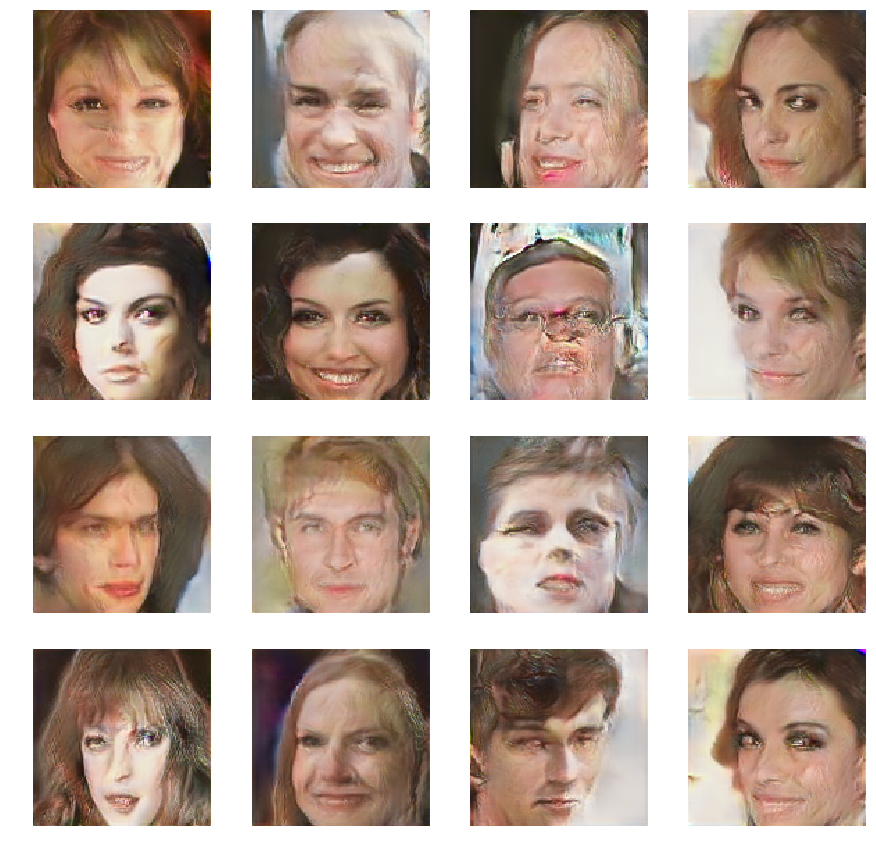

In [90]:
NOISE.data.normal_()
show((generator(NOISE, 5) + 1) / 2, 16, square=True)

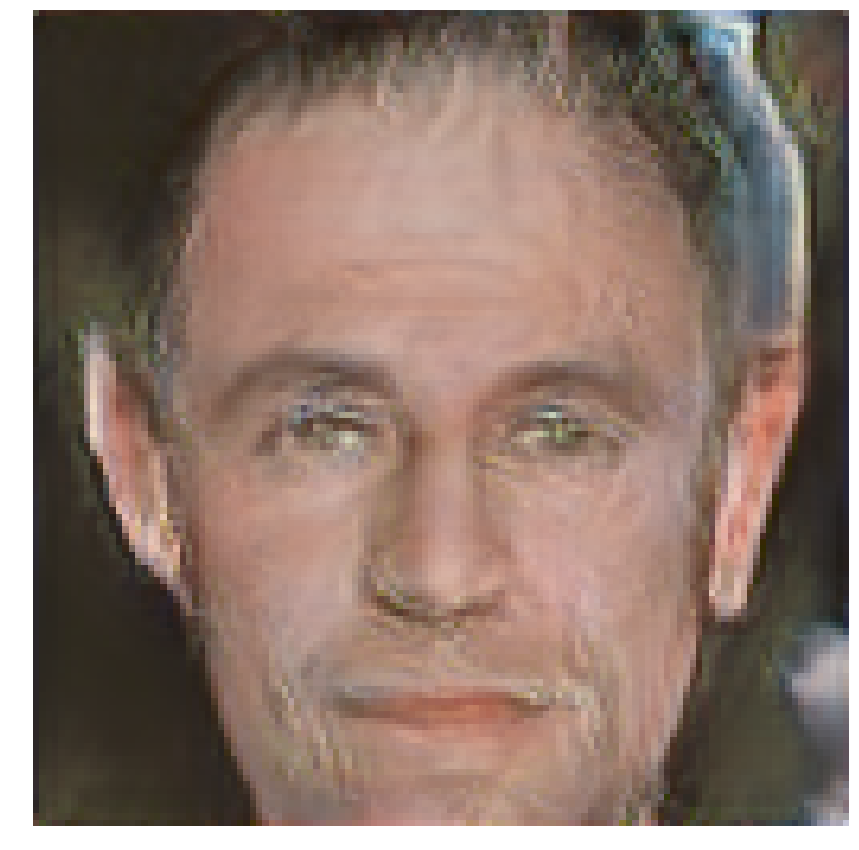

In [93]:
sample = ((generator(get_noise(2, 256).cuda(), 5) + 1) / 2)[0:2]
show(sample, 1, square=True)

In [74]:
# noise_one = NOISE.data.normal_().cuda(2)[0]
# noise_two = NOISE.data.normal_().cuda(2)[1] 
# noise_thr = NOISE.data.normal_().cuda(2)[2]
# noise_fou = NOISE.data.normal_().cuda(2)[3]

# fig_shape = 5

# # 1 -> 2
# noises_o_t = []
# for alpha in np.linspace(0., 1., fig_shape):
#     noises_o_t.append((1. - alpha) * noise_one + alpha * noise_two)
# # 1 -> 3
# noises_o_th = []
# for alpha in np.linspace(0., 1., fig_shape):
#     noises_o_th.append((1. - alpha) * noise_one + alpha * noise_thr)
# # 2 -> 4
# noises_t_f = []
# for alpha in np.linspace(0., 1., fig_shape):
#     noises_t_f.append((1. - alpha) * noise_two + alpha * noise_fou)
# # 3 -> 4
# noises_th_f = []
# for alpha in np.linspace(0., 1., fig_shape):
#     noises_th_f.append((1. - alpha) * noise_thr + alpha * noise_fou)
    
# noises_middle = []
# for i in range(fig_shape - 2):
#     noises_tmp = []
#     n_one = noises_o_th[1 + i]
#     n_two = noises_t_f[1 + i]
#     for alpha in np.linspace(0., 1., fig_shape):
#         noises_tmp.append((1. - alpha) * n_one + alpha * n_two)
#     noises_middle.append(noises_tmp)

In [75]:
# print(len(noises_middle))

In [76]:
# plt.figure(figsize=(100,100))
# for idx, noise in enumerate(noises_o_t):
#     img = generator(noise.view(1, 256).cuda(), 5)
#     img = img.permute(0, 2, 3, 1)
#     img = np.clip((img.cpu().data.numpy() + 1.) / 2., 0, 1)[0]
#     plt.subplot(fig_shape, fig_shape, idx + 1)
#     plt.imshow(img)  
#     plt.axis('off')
    
# for idx, noise in enumerate(noises_o_th):
#     img = generator(noise.view(1, 256).cuda(), 5)
#     img = img.permute(0, 2, 3, 1)
#     img = np.clip((img.cpu().data.numpy() + 1.) / 2., 0, 1)[0]
#     plt.subplot(fig_shape, fig_shape, fig_shape * idx + 1)
#     plt.imshow(img)  
#     plt.axis('off')
    
# for idx, noise in enumerate(noises_th_f):
#     img = generator(noise.view(1, 256).cuda(), 5)
#     img = img.permute(0, 2, 3, 1)
#     img = np.clip((img.cpu().data.numpy() + 1.) / 2., 0, 1)[0]
#     plt.subplot(fig_shape, fig_shape, fig_shape * (fig_shape - 1) + 1 + idx)
#     plt.imshow(img)  
#     plt.axis('off')
    
# for idx, noise in enumerate(noises_t_f):
#     img = generator(noise.view(1, 256).cuda(), 5)
#     img = img.permute(0, 2, 3, 1)
#     img = np.clip((img.cpu().data.numpy() + 1.) / 2., 0, 1)[0]
#     plt.subplot(fig_shape, fig_shape, fig_shape * idx + fig_shape)
#     plt.imshow(img)  
#     plt.axis('off')
    
# for idx in range(fig_shape - 2):
#     for jdx in range(fig_shape - 2):
#         img = generator(noises_middle[idx][jdx].view(1, 256).cuda(), 5)
#         img = img.permute(0, 2, 3, 1)
#         img = np.clip((img.cpu().data.numpy() + 1.) / 2., 0, 1)[0]
#         plt.subplot(fig_shape, fig_shape, fig_shape * (1 + idx) + 1 + jdx + 1)
#         plt.imshow(img)  
#         plt.axis('off')

In [77]:
def find_closest_MSE(sample):
    closest = None
    min_dist = 10000000.
    try:
        for idx in range(12662):
            if idx % 1000 == 0:
                print (idx)
            im = data_acc.get_next()
            for i in im:
                dist = nn.MSELoss()(sample, i.cuda())
                if dist < min_dist:
                    closest = i
                    min_dist = dist
        return closest
    except KeyboardInterrupt:
        return closest

In [78]:
def find_closest_MAE(sample):
    closest = None
    min_dist = 10000000.
    try:
        for idx in range(12662):
            if idx % 1000 == 0:
                print (idx)
            im = data_acc.get_next()
            for i in im:
                dist = nn.MAELoss()(sample, i.cuda())
                if dist < min_dist:
                    closest = i
                    min_dist = dist
        return closest
    except KeyboardInterrupt:
        return closest

In [79]:
def find_closest_good(sample):
    closest = None
    min_dist = 10000000.
    try:
        for idx in range(12662):
            if idx % 1000 == 0:
                print (idx)
            im = data_acc.get_next()
            dist = model.forward(sample, im.permute(0, 3, 1, 2))
            best_idx = np.argmin(dist)
            closest = im[best_idx]
            min_dist = dist[best_idx]
        return closest
    except KeyboardInterrupt:
        return closest

In [80]:
# ## Lowest basemark
# samples_equal = []
# for idx, (imgs, _) in enumerate(dataloader):
#     if idx * 16 > 5000:
#         break
#     for img in imgs:
#         samples_equal.append(sample_one[0].data.clone().cpu().numpy())
# inception_score(samples_equal, resize=True, batch_size=1)

In [81]:
# # Highest basemark Celeba
# samples_celeba_real = []
# for idx, imgs in enumerate(celeba_dataloader):
#     if idx * 16 > 1000:
#         break
#     for img in imgs:
#         samples_celeba_real.append(img.permute(2, 1, 0))
# inception_score(samples_celeba_real, resize=True, cuda=False, splits=10)

In [82]:
# # WGAN Celeba evaluation
# samples_celeba_fake = []
# _samples = generator(get_noise(280, 256).cuda(), 5)
# for _ in range(len(_samples)):
#     _sample = (_samples[_] + 1.) / 2.
#     samples_celeba_fake.append(_sample)
# inception_score(samples_celeba_fake, resize=True, splits=10)

In [94]:
sample.shape

torch.Size([2, 3, 128, 128])

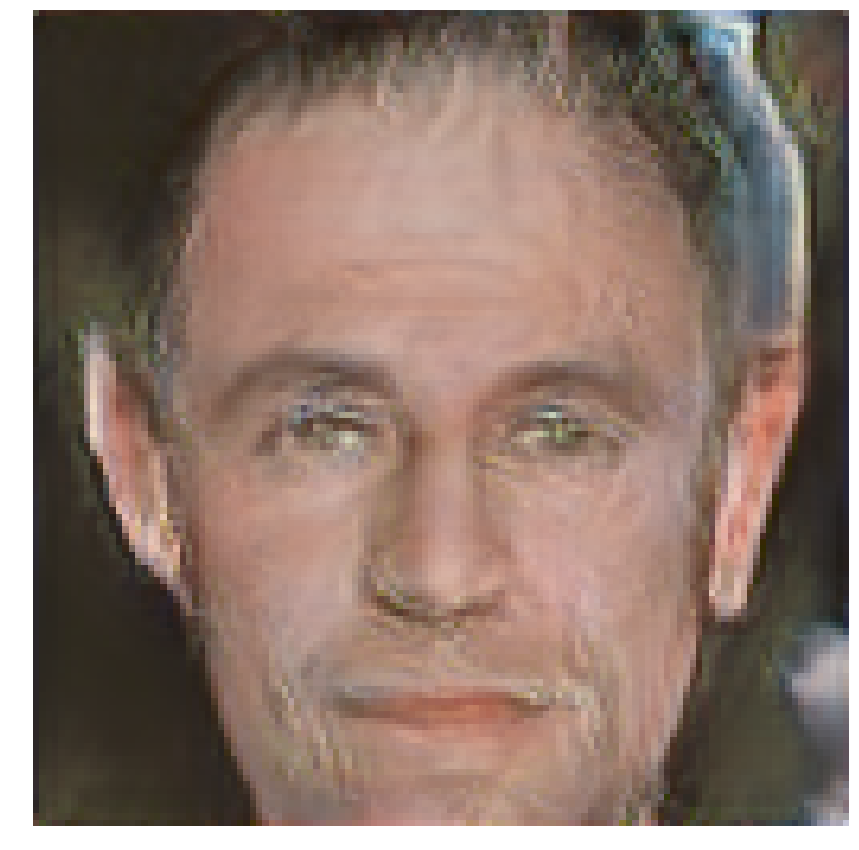

In [95]:
sample_one = sample[0].view(1, 3, 128, 128)
show(sample_one, 1, square=True)

In [96]:
closest_MSE = find_closest_MSE(sample.cuda()[0].permute(1,2,0))

0
DataAcc reinit
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


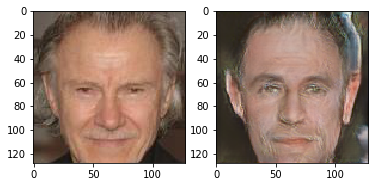

In [97]:
plt.subplot(1, 2, 1)
plt.imshow(closest_MSE)
plt.subplot(1, 2, 2)
#show(sample_one, 1, square=True)
plt.imshow(np.clip((sample.permute(0, 2, 3, 1).data[0]), 0, 1))

In [ ]:
closest_MAE = find_closest_good(sample.cuda()[0].permute(1,2,0))

In [98]:
model = dm.DistModel()
model.initialize(model='net-lin',net='alex',use_gpu=True)

In [99]:
closest_per = find_closest_good(sample.cuda()[0].contiguous().view(1, 128, 128, 3).permute(0, 3, 1, 2))

0
DataAcc reinit
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


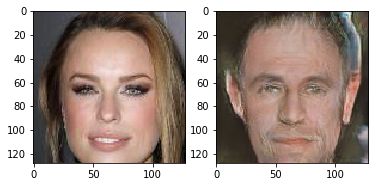

In [100]:
plt.subplot(1, 2, 1)
plt.imshow(closest_per)
plt.subplot(1, 2, 2)

plt.imshow(np.clip((sample_one[0].permute(1,2,0).cpu().data.numpy()), 0, 1))

In [ ]:
import sys
sys.path.insert(0, './inception-score-pytorch/')
from inception_score import inception_score

In [ ]:
samples = []
_samples = generator(get_noise(400, 256).cuda(), 5)
for _ in range(len(_samples)):
    _sample = _samples[_:_+1][0]
    samples.append(_sample)

In [ ]:
inception_score(samples, resize=True)